[View in Colaboratory](https://colab.research.google.com/github/tjh48/DCGAN/blob/master/rajathkmp_gan_model_based.ipynb)

From https://github.com/rajathkmp/DCGAN/blob/master/dcgan.py

In [0]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os

from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.layers.core import Flatten
from keras.optimizers import SGD, Adam
from keras.datasets import mnist
from keras.utils import np_utils
from keras.initializers import *

In [0]:
def dataInit():
	print('Loading the data')
	(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
	X_train = np.concatenate((X_train, X_test), axis=0)
	X_train = (X_train.astype(np.float32) - 127.5)/127.5
	print('Training Data: ', X_train.shape)
	npRandom = np.random.RandomState(18)
	X_noise = []
	for i in range(X_train.shape[0]):
		randomNoise = npRandom.uniform(-1,1,100)
		X_noise.append(randomNoise)
	X_noise = np.array(X_noise)
	print('Random Noise Data: ', X_noise.shape)
	return X_train, X_noise

In [0]:
def saveImage(imageData, imageName, epoch):
	f, ax = plt.subplots(16, 8)
	k = 0
	for i in range(16):
		for j in range(8):
			pltImage = imageData[k][0]
			ax[i,j].imshow(pltImage, interpolation='nearest',cmap='gray_r')
			ax[i,j].axis('off')
			k = k+1
	f.set_size_inches(18.5, 10.5)
	f.savefig('images/'+imageName+'_after_'+str(epoch)+'_epoch.png', dpi = 100, bbox_inches='tight', pad_inches = 0)
	plt.close(f)
	return None

In [0]:
def initNormal(shape):
	return RandomNormal(shape, stddev=0.02)


In [14]:
batchSize = 128
nbEpoch = 200
decayIter = 100
lr = 0.0002

X_train, X_noise = dataInit()
X_train = X_train[:, :, :, np.newaxis]
numExamples = (X_train.shape)[0]
numBatches = int(numExamples/float(batchSize))

print('Number of examples: ', numExamples)
print('Number of Batches: ', numBatches)
print('Number of epochs: ', nbEpoch)

adam=Adam(lr=lr, beta_1=0.5 )

print('Generator Model')

input = Input(shape=(100,))
gen = Dense(128*7*7)(input)
gen = Activation('relu')(gen)
gen = Reshape((7, 7, 128))(gen)	
gen = UpSampling2D(size=(2, 2), data_format='channels_last')(gen)
gen = Convolution2D(64, nb_row = 5, nb_col = 5, subsample = (1,1), border_mode='same', data_format='channels_last')(gen)
gen = Activation('relu')(gen)
gen = UpSampling2D(size=(2, 2), data_format='channels_last')(gen)
gen = Convolution2D(1, nb_row = 5, nb_col = 5, subsample = (1,1), border_mode='same', data_format='channels_last')(gen)
gen = Activation('tanh')(gen)
generator = Model(input, gen)
generator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
  
generator.summary()

Loading the data
('Training Data: ', (70000, 28, 28))
('Random Noise Data: ', (70000, 100))
('Number of examples: ', 70000)
('Number of Batches: ', 546)
('Number of epochs: ', 200)
Generator Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6272)              633472    
_________________________________________________________________
activation_5 (Activation)    (None, 6272)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_5 (C

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same", strides=(1, 1), data_format="channels_last")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (5, 5), padding="same", strides=(1, 1), data_format="channels_last")`


In [15]:
print('Discriminator Model')

inputImage = Input(shape=(28, 28, 1))
disc = Convolution2D(64, nb_row = 5, nb_col = 5, border_mode='same', subsample=(2,2), input_shape=(28,28,1), data_format='channels_last')(inputImage)
disc = LeakyReLU(0.2)(disc)
disc = Convolution2D(128, nb_row = 5, nb_col = 5, border_mode='same', subsample=(2,2), data_format='channels_last')(disc)
disc = LeakyReLU(0.2)(disc)
disc = Flatten()(disc)
disc = Dense(1)(disc)
disc = Activation('sigmoid')(disc)
discriminator = Model(inputImage, disc)
discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

discriminator.trainable = False

discriminator.summary()

Discriminator Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), data_format="channels_last", input_shape=(28, 28, 1..., padding="same", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), padding="same", strides=(2, 2), data_format="channels_last")`
  


In [16]:
	print('DCGAN model')

	dcganInput = Input(shape=(100,))
	x = generator(dcganInput)
	dcganOutput = discriminator(x)
	dcgan = Model(input=dcganInput, output=dcganOutput)
	dcgan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

	discriminator.trainable = True

DCGAN model


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("mo..., inputs=Tensor("in...)`
  


In [0]:
def plotImages(images, n = 25):
  plt.figure(figsize=(32, 32))
  for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    x = images[i]
    if x.shape[2] == 1: x = x.reshape(x.shape[0:2])
    plt.imshow((x + 1) / 2)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

('Epoch: ', 1)


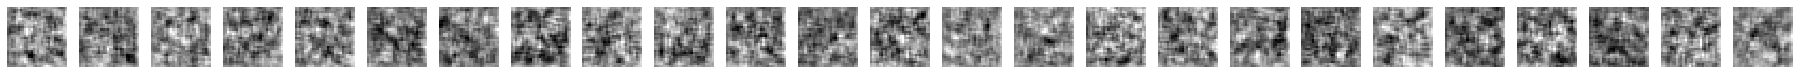

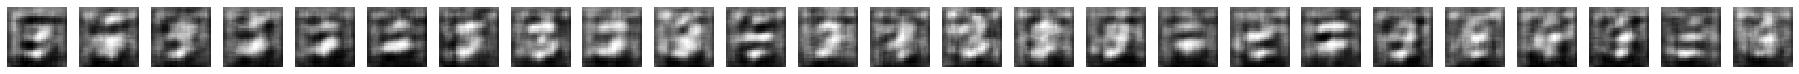

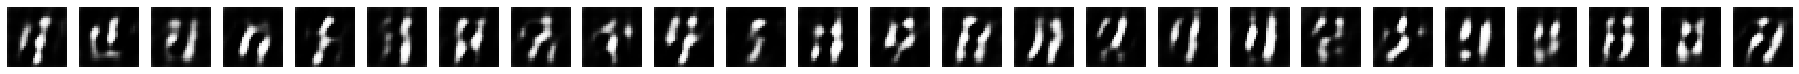

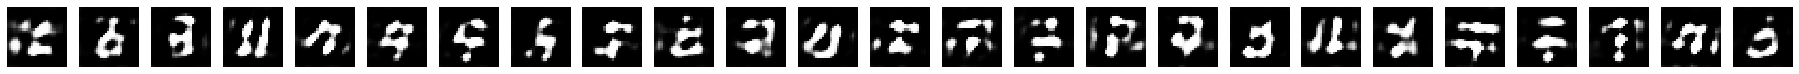

In [0]:
if not os.path.exists('images'):
  os.makedirs('images')
if not os.path.exists('models'):
	os.makedirs('models')
if not os.path.exists('metrics'):
	os.makedirs('metrics')

dLoss = []
gLoss = []

for epoch in range(1, nbEpoch + 1):
	print('Epoch: ', epoch)

	for i in range(numBatches):
		noisePredictBatch = X_noise[np.random.randint(numExamples, size = batchSize)]
		noiseDataBatch = generator.predict(noisePredictBatch)
		origDataBatch = X_train[np.random.randint(numExamples, size = batchSize)]
		noiseLabelsBatch, origLabelsBatch = np.zeros(batchSize).astype(int), np.ones(batchSize).astype(int)
		trainBatch = np.concatenate((noiseDataBatch, origDataBatch), axis = 0)
		trainLabels = np.concatenate((noiseLabelsBatch, origLabelsBatch))
		trainBatch, trainLabels = shuffle(trainBatch, trainLabels)
		discriminatorLoss = discriminator.train_on_batch(trainBatch, trainLabels)
		dcganLabels = np.ones(batchSize).astype(int)			
		discriminator.trainable = False
		dcganLoss = dcgan.train_on_batch(noisePredictBatch, dcganLabels)
		discriminator.trainable = True
		if (i % 50 == 0): plotImages(noiseDataBatch)
	dLoss.append(discriminatorLoss)
	gLoss.append(dcganLoss)
  
	if (epoch % 1 == 0) or (epoch == 1):
		saveImage(noiseDataBatch, 'generated', epoch)
		print('after epoch: ', epoch)
		print ('dcgan Loss: ', dcganLoss, '\t discriminator loss', discriminatorLoss)
		generator.save('models/generator_'+str(epoch)+'.h5')
		plotImages(noiseDataBatch)
	if epoch > decayIter :
		lrD = discriminator.optimizer.lr.get_value()
		lrG = generator.optimizer.lr.get_value()
		discriminator.optimizer.lr.set_value((lrD - lr/decayIter).astype(np.float32))
		generator.optimizer.lr.set_value((lrG - lr/decayIter).astype(np.float32))
		print('learning rate linearly decayed')